```mermaid
graph TD
a(三元阵列数据)--线性预测虚拟阵元在三阵元间补阵元, 减小阵元间距--> b(阵元间距小于半波长/宽带互谱最大距离的N元阵列数据)
b--stft-->c(时频图)--相位信息-->d(有注意力的时频相位图)-->h(lstm)-->i(距离, 角度)
c--幅度信息-->f(时频幅度图)--给出时频注意力, 聚焦有脉冲的部分-->d
f--常规波束形成-->短时空间谱-->i
```

宽带信号互谱法要求$d\le \frac{c}{2B}$, 当带宽B=500Hz, d_max = 1.5m

加有方位的噪声源允许学习出空间特性

由于注意力应当与空间, 频率, 相位相关, 因此必然要学习参数, SimAm这样的无参数注意力层肯定不行

在标签处加白噪声, 模拟采样不准情况

In [1]:
import os

os.environ['WANDB_NOTEBOOK_NAME'] = os.path.abspath('.') + '/wideband_cpsd_cnn.ipynb'
import numpy as np
import torch
import torchmetrics
import wandb
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchkeras import KerasModel
from torchmetrics import Accuracy
from torchkeras import kerascallbacks

import Datasets
import feature_modules

## 数据准备

### 数据处理

先分批将每个样本中数据按时间窗转为频相图, 作为特征

In [2]:
c = 1500
fc = 42500
fs_factor = 8
fs = fs_factor * fc
d = 0.5
K = 1.0
SNR = 'ideal'
r_range = (200, 600)
dist_max = d * (K + 1)
maxlag = int(np.ceil(dist_max / c * fs))  # 当前采样频率下最大滞后量
sample_interval = 1

dataset_path = f'/root/autodl-tmp/dataset/fc_{fc}-fs_factor_{fs_factor}-d_{d}-K_{K}-SNR_{SNR}-r_{r_range[0]}_{r_range[1]}'
train_path = f'{dataset_path}/train'
val_path = f'{dataset_path}/val'
checkpoint_path = "./exp/checkpoint"

label_type = 'position'
batch_size = 70

ds_train = Datasets.Array_Data_DataSet(train_path, label_type=label_type, distance_range=r_range)
ds_val = Datasets.Array_Data_DataSet(val_path, label_type=label_type, distance_range=r_range)
# plt.subplot(2, 1, 1)
# plt.plot(ds_train[np.random.randint(len(ds_train))][0][0, ::50])
# plt.subplot(2, 1, 2)
# plt.plot(ds_val[np.random.randint(len(ds_val))][0][1, ::50])
# plt.show()

# 取样时有打乱
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=16, drop_last=False)
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=True, num_workers=16, drop_last=False)

## 模型定义

In [3]:
from typing import Literal
from torchvision.models import resnet18, ResNet18_Weights, resnet50

class Predictor(nn.Module):
    def __init__(self, label_type: Literal['direction', 'position']):
        super().__init__()
        weights = ResNet18_Weights.DEFAULT
        self.spectrogram = feature_modules.Spectrogram(fs, 16384, 16)
        self.filter = feature_modules.Filter(fs, 16384, 42.5e3)
        # self.cpsd_phase = feature_modules.CPSD_Phase_Spectrogram()
        self.transforms = weights.transforms(antialias=True)
        # self.resnet18 = resnet50()
        self.backbone = resnet18()
        self.backbone.fc = torch.nn.Linear(in_features=self.backbone.fc.in_features, out_features=2 if label_type == 'direction' else 3)
        # TODO: Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.spectrogram(x.unsqueeze(1))
        x = self.filter(x)
        # x = torch.angle(x)
        x = self.cpsd_phase(x)
        x = self.backbone(x)
        x = torch.tanh(x)
        return x

## 模型训练

<<<<<< ⚡️ cuda is used >>>>>>


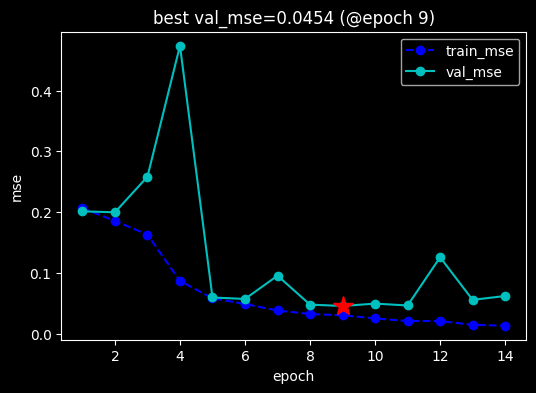

<<<<<< val_mse without improvement in 5 epoch,early stopping >>>>>> 



,epoch,train_loss,train_mse,lr,val_loss,val_mse
0,1,0.206369,0.206493,0.000100,0.200962,0.201131
1,2,0.185298,0.185378,0.000100,0.200524,0.199636
2,3,0.162681,0.162813,0.000100,0.257114,0.258149
3,4,0.086569,0.086702,0.000100,0.472655,0.473700
4,5,0.058105,0.058175,0.000050,0.059270,0.059428
5,6,0.048641,0.048696,0.000050,0.057930,0.056973
6,7,0.037983,0.038010,0.000050,0.095284,0.095316
7,8,0.032278,0.032228,0.000050,0.048105,0.047653
8,9,0.030004,0.030054,0.000025,0.045201,0.045428
9,10,0.025026,0.025011,0.000025,0.049406,0.049333


In [4]:
from torchkeras.kerascallbacks import WandbCallback
from argparse import Namespace

def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.normal_(m.weight)
        m.bias.data.fill_(0.0)

net = Predictor(label_type)  # type: ignore
# net.apply(init_weights)  # 初始化权重为全零

lr = 1e-4
# optimizer=optim.SGD(net.parameters(), lr=lr)
optimizer=optim.Adam(net.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

model = KerasModel(
    net,
    # loss_fn=loss_with_regulation,
    # loss_fn=nn.L1Loss(),
    loss_fn=nn.MSELoss(),
    metrics_dict={
        # 'L1': torchmetrics.MeanAbsoluteError(),
        'mse': torchmetrics.MeanSquaredError(),
    },
    optimizer=optimizer,
    lr_scheduler=lr_scheduler
)

model.fit(
    dl_train,
    dl_val,
    epochs=20,
    ckpt_path='exp/checkpoint',
    patience=5,
    monitor='val_mse',
    mode='min',
    plot=False,
    quiet=True,
    callbacks=[
        kerascallbacks.VisProgress(),
        kerascallbacks.VisMetric(save_path='exp/history.jpg'),
        # WandbCallback(project='wideband_cpsd_cnn', save_code=True, save_ckpt=True,
        #     config=Namespace(
        #         batch_size=batch_size,
        #         lr=lr,
        # )),
    ]
)

## 模型分析

### 特征图

In [15]:
checkpoint = torch.load(checkpoint_path)
net = Predictor(label_type)  # type: ignore
net.load_state_dict(checkpoint)
net.eval()
net.cuda()

# take out all meaningful conv2 layers in the net
model_weights =[]
conv_layers = []

model_children = list(net.backbone.children())
counter = 0

for child in model_children:
    if type(child) == nn.Conv2d:
        counter+=1
        model_weights.append(child.weight)
        conv_layers.append(child)
    elif type(child) == nn.Sequential:
        for gChild in child:
            for ggChild in gChild.children():
                if type(ggChild) == nn.Conv2d:
                    counter+=1
                    model_weights.append(ggChild.weight)
                    conv_layers.append(ggChild)

print(counter)

17


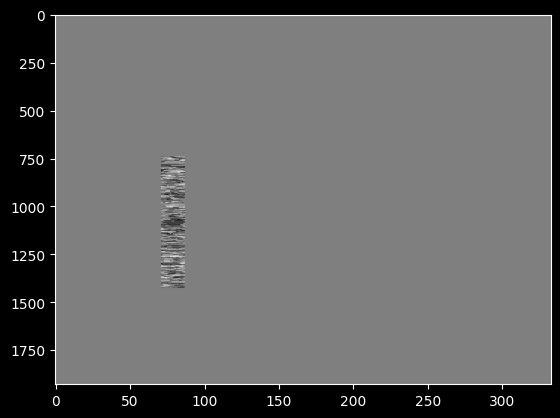

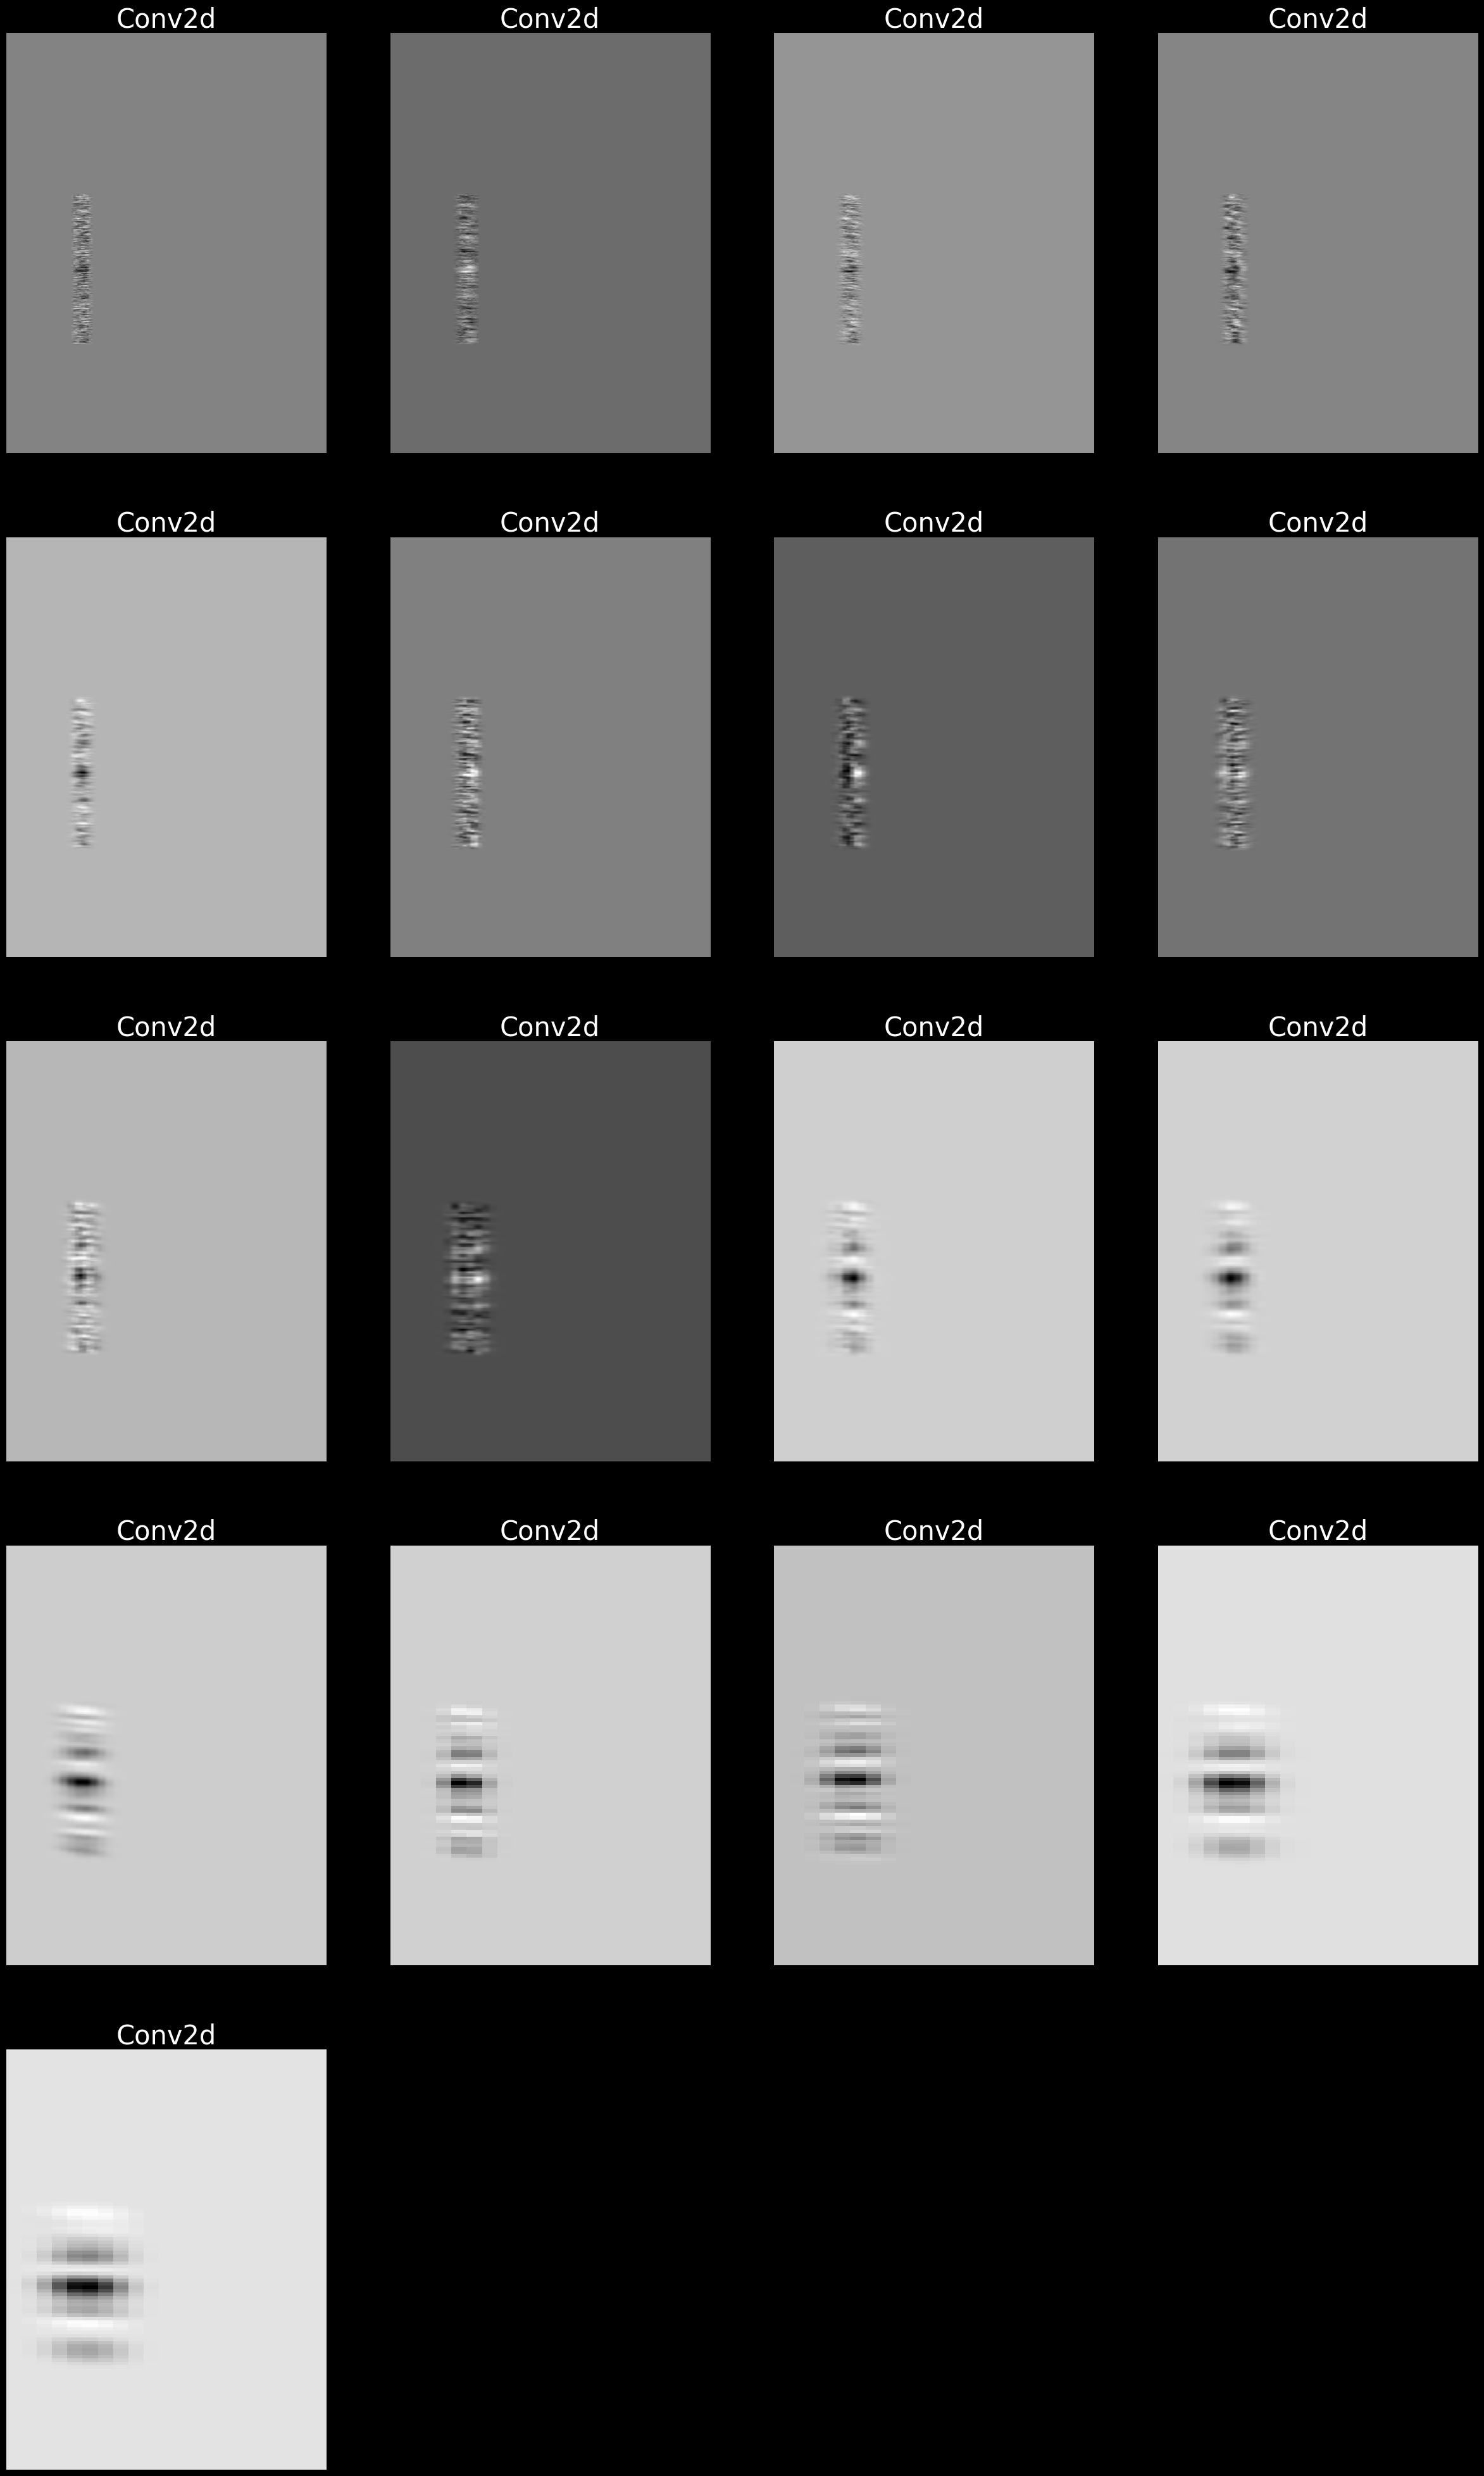

In [21]:
# %matplotlib widget

# feed a input and obtain all feature maps
input = ds_train[-1][0].cuda()
feature = net.cpsd_phase(net.filter(net.spectrogram(input.unsqueeze(0).unsqueeze(0)))).squeeze()
plt.imshow(feature[0].cpu(), aspect='auto', cmap='gray')
input = feature
# input = net.transforms(input)
outputs = []
names = []
for layer in conv_layers:
    input = layer(input)
    outputs.append(input)
    names.append(str(layer))
# for feature_map in outputs:
#     print(feature_map.shape)
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
# for fm in processed:
#     print(fm.shape)

fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i], aspect='auto', cmap='gray')
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)

## 模型评估

### 标签为$(cos(\theta), sin(\theta))$

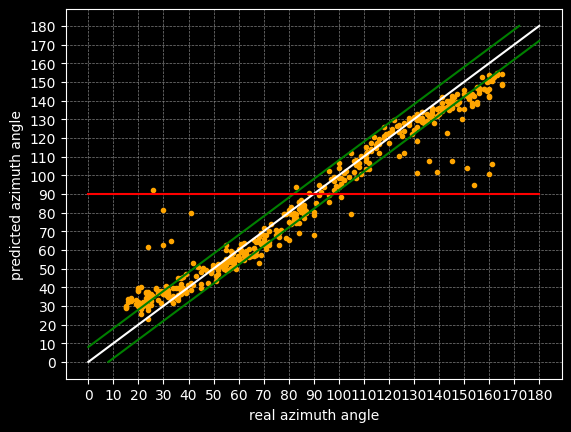

In [5]:
checkpoint = torch.load(checkpoint_path)
net = Predictor(label_type)  # type: ignore
net.load_state_dict(checkpoint)
net.eval()
net.cuda()

dl_val = DataLoader(ds_val, batch_size=80, shuffle=False, num_workers=16, drop_last=False)
for data, labels in dl_val:
    predicted = net(data.cuda()).detach().cpu()
    label_angles = ds_val.labels2angles(labels)
    predicted_angles = ds_val.labels2angles(predicted)
    plt.plot(label_angles, predicted_angles, '.', color='orange')
plt.plot([0, 180], [0, 180], 'white')
plt.plot([0, 172], [8, 180], 'green')
plt.plot([8, 180], [0, 172], 'green')
plt.plot([0, 180], [90, 90], 'red')

plt.xlabel('real azimuth angle')
plt.ylabel('predicted azimuth angle')
plt.xticks(np.arange(0, 190, 10))
plt.yticks(np.arange(0, 190, 10))
plt.grid(True, which='major', color='gray', linestyle='--', linewidth=0.5)

### 标签为$(cos(\theta), sin(\theta), r)$

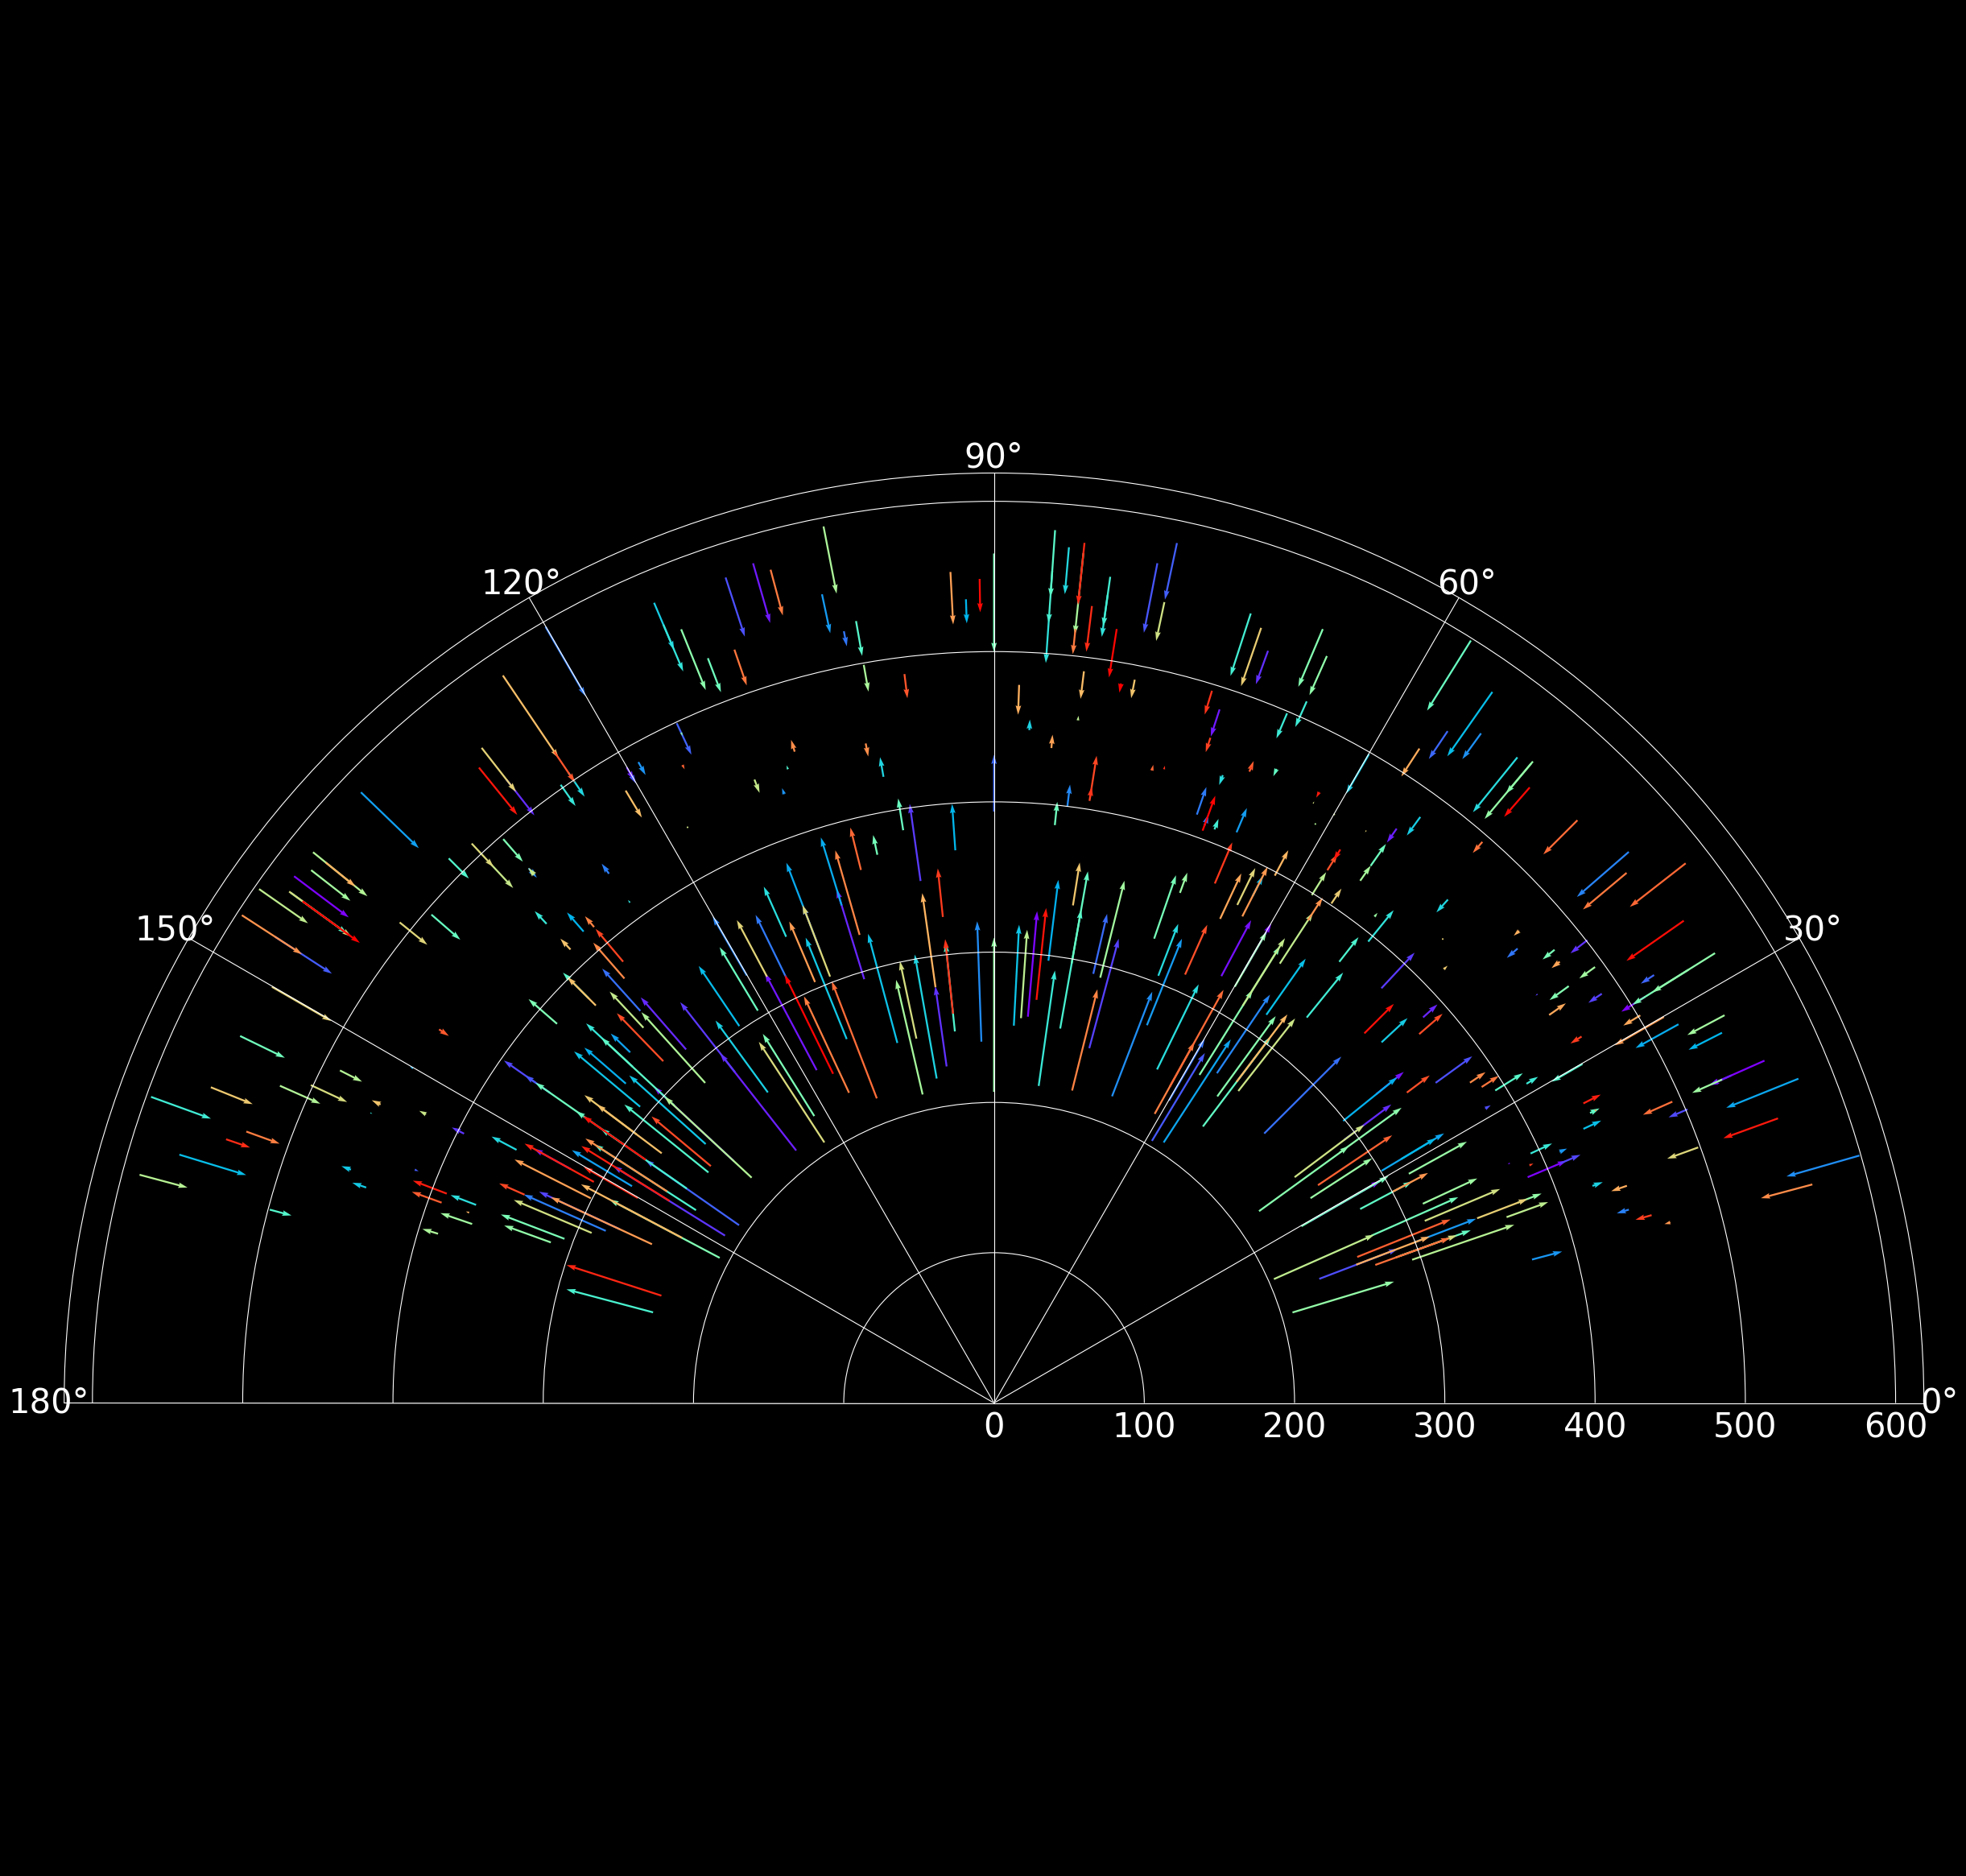

In [6]:
import matplotlib.cm as cm

# Generate a color array
colors = cm.rainbow(np.linspace(0, 1, len(ds_val)))  # type: ignore

checkpoint = torch.load(checkpoint_path)
net = Predictor(label_type)  # type: ignore
net.load_state_dict(checkpoint)
net.eval()
net.cuda()

if label_type == 'position':
    plt.figure(figsize=(30, 30))
    ax = plt.subplot(111, polar=True)
    ax.set_xlim(0, np.pi)
    # ax.set_ylim(top=1000)
    ax.tick_params(axis='both', which='major', labelsize=30)

    dl_val = DataLoader(ds_val, batch_size=80, shuffle=False, num_workers=16, drop_last=False)
    total_label_thetas = torch.zeros(len(ds_val))
    total_label_distances = torch.zeros(len(ds_val))
    total_diff_x = torch.zeros(len(ds_val))
    total_diff_y = torch.zeros(len(ds_val))
    for i, (data, labels) in enumerate(dl_val):
        predicted = net(data.cuda()).detach().cpu()
        label_distances, label_angles = ds_val.labels2positions(labels)
        label_thetas = torch.deg2rad(label_angles)
        predicted_distances, predicted_angles = ds_val.labels2positions(predicted)
        predicted_thetas = torch.deg2rad(label_angles)
        # Convert polar coordinates to Cartesian coordinates
        label_x = label_distances * torch.cos(label_thetas)
        label_y = label_distances * torch.sin(label_thetas)
        predicted_x = predicted_distances * torch.cos(predicted_thetas)
        predicted_y = predicted_distances * torch.sin(predicted_thetas)
        # Calculate differences for the quiver function
        diff_x = predicted_x - label_x
        diff_y = predicted_y - label_y

        total_label_thetas[i*80:min((i+1)*80, len(ds_val))] = label_thetas
        total_label_distances[i*80:min((i+1)*80, len(ds_val))] = label_distances
        total_diff_x[i*80:min((i+1)*80, len(ds_val))] = diff_x
        total_diff_y[i*80:min((i+1)*80, len(ds_val))] = diff_y

    # ax.quiver(total_label_thetas[-100:], total_label_distances[-100:], total_diff_x[-100:], total_diff_y[-100:], color=colors, width=0.001, headwidth=3)
    ax.quiver(total_label_thetas, total_label_distances, total_diff_x, total_diff_y, color=colors, width=0.001, headwidth=3)
    plt.show()